# Ensemble Methods

Este notebook implementa diferentes métodos de ensemble para combinar las predicciones de múltiples modelos de machine learning y mejorar el rendimiento predictivo.

Los métodos implementados son:
1. Votación (Voting): La clase predicha es la que obtiene más votos de los modelos individuales
2. Media (Mean): Combina las probabilidades predichas usando la media
3. Mediana (Median): Combina las probabilidades predichas usando la mediana

## 1. Método de Votación (Voting Ensemble)

El método de votación combina las predicciones de múltiples modelos mediante un sistema de votos. La clase que recibe más votos es seleccionada como la predicción final del ensemble.

In [4]:
import numpy as np
from collections import Counter

def voting_ensemble(predictions_list: list, probabilities_list: list = None) -> np.ndarray:
    
    # Convertir todas las predicciones a arrays numpy
    predictions_array = np.array(predictions_list)  # shape: (n_models, n_samples)
    n_models, n_samples = predictions_array.shape
    
    final_predictions = np.zeros(n_samples, dtype=int)
    
    # Para cada muestra, contar los votos
    for i in range(n_samples):
        sample_predictions = predictions_array[:, i]
        
        vote_counts = Counter(sample_predictions)
        
        max_votes = max(vote_counts.values())
        
        tied_classes = [cls for cls, count in vote_counts.items() if count == max_votes]
        
        # Si hay empate y tenemos probabilidades, usar ponderación
        if len(tied_classes) > 1 and probabilities_list is not None:
            # Calcular la suma de probabilidades ponderadas para cada clase empatada
            weighted_probs = {}
            
            for cls in tied_classes:
                total_prob = 0.0
                
                # Sumar las probabilidades de los modelos que votaron por esta clase
                for model_idx in range(n_models):
                    if predictions_array[model_idx, i] == cls:
                        # Obtener la probabilidad que el modelo asignó a esta clase
                        prob = probabilities_list[model_idx][i, int(cls)]
                        total_prob += prob
                
                weighted_probs[cls] = total_prob
            
            # Seleccionar la clase con mayor suma de probabilidades
            final_predictions[i] = max(weighted_probs.items(), key=lambda x: x[1])[0]
        
        else:
            # Si no hay empate o no hay probabilidades, tomar la clase más votada
            # En caso de empate sin probabilidades, Counter devuelve una arbitrariamente
            final_predictions[i] = vote_counts.most_common(1)[0][0]
    
    return final_predictions

## 2. Método de Media (Mean Ensemble)

In [5]:
def mean_ensemble(probabilities_list: list) -> tuple:
    probabilities_array = np.array(probabilities_list)
    mean_probabilities = np.mean(probabilities_array, axis=0)
    final_predictions = np.argmax(mean_probabilities, axis=1)
    
    return final_predictions, mean_probabilities

## 3. Método de Mediana (Median Ensemble)

In [9]:
def median_ensemble(probabilities_list: list) -> tuple:
    probabilities_array = np.array(probabilities_list)
    median_probabilities = np.median(probabilities_array, axis=0)
    final_predictions = np.argmax(median_probabilities, axis=1)
    
    return final_predictions, median_probabilities

## Prueba del Ensemble con Modelos Pre-entrenados

A continuación, probamos el método de votación con los modelos reales que ya han sido entrenados, sin necesidad de reentrenarlos.

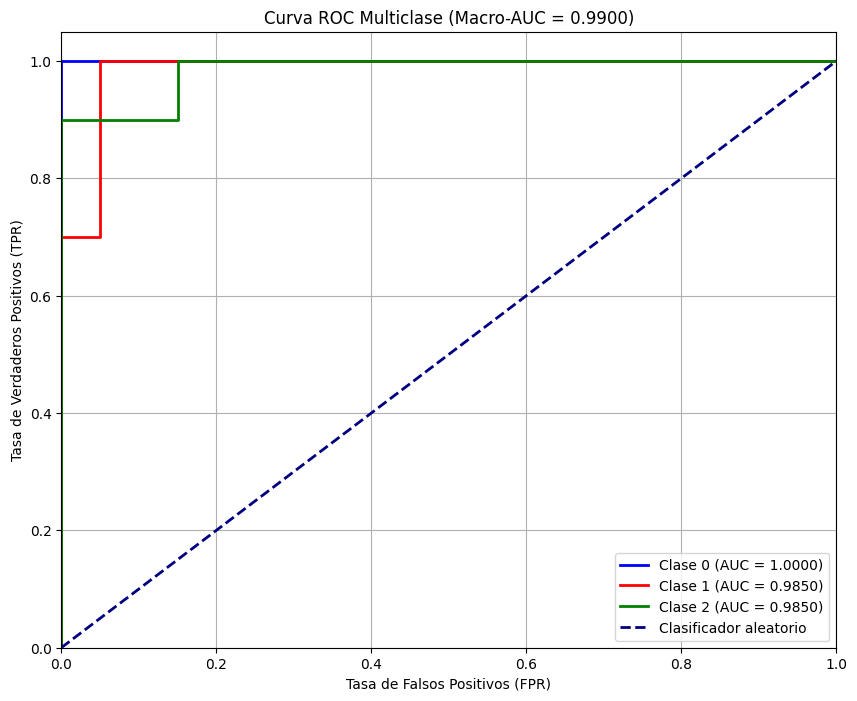

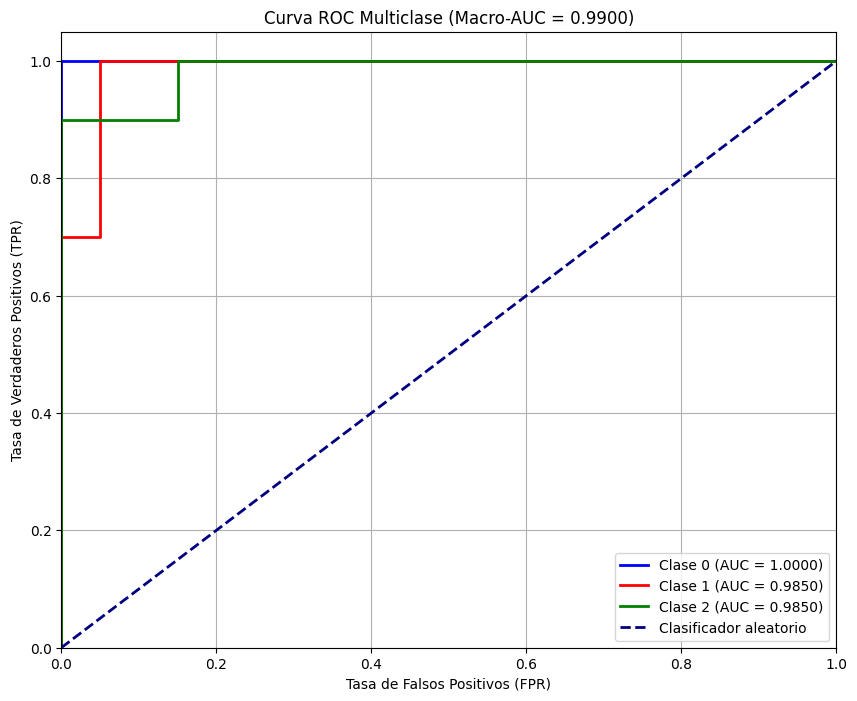

NameError: name 'probabilities_array' is not defined

In [8]:
import joblib
import pandas as pd
import os
import sys

from eval import evaluate_model

transformations = ["norm", "original", "std"]
PCA_values = [0, 80, 95]

for iteration in range(1, 6):
    for transform in transformations:
        for pca_value in PCA_values:

            if pca_value > 0:
                test_file = f"cross_validation_data/test{iteration}_{transform}_PCA{pca_value}.csv"
                model_suffix = f"{transform}_PCA{pca_value}_{iteration}"
            else:
                test_file = f"cross_validation_data/test{iteration}_{transform}.csv"
                model_suffix = f"{transform}_{iteration}"
            
            df_test = pd.read_csv(test_file)
            X_test = df_test.iloc[:, :-1].astype(float)
            y_test = df_test.iloc[:, -1].astype(int).to_numpy()
            
            predictions_list = []
            probabilities_list = []
            
            model_types = ['KNN', 'SVM', 'RF', 'NB']
            models_loaded = 0
            
            for model_type in model_types:
                model_path = f"cross_validation_models/{model_type}_{model_suffix}.pkl"
                
                model = joblib.load(model_path)
                    
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)
                 
                predictions_list.append(y_pred)
                probabilities_list.append(y_prob)
                models_loaded += 1

            y_pred_voting = voting_ensemble(predictions_list, probabilities_list)
            y_prob_voting = np.mean(probabilities_list, axis=0)
            evaluate_model(y_test, y_pred_voting, y_prob_voting, f"VotingEnsemble_{model_suffix}")
            
            y_pred_mean, y_prob_mean = mean_ensemble(probabilities_list)
            evaluate_model(y_test, y_pred_mean, y_prob_mean, f"MeanEnsemble_{model_suffix}")
            
            y_pred_median, y_prob_median = median_ensemble(probabilities_list)
            evaluate_model(y_test, y_pred_median, y_prob_median, f"MedianEnsemble_{model_suffix}")
